In [1]:
# Import libraries
import sys

import networkx as nx
import pandas as pd
import numpy as np
import os

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.mapper import GraphSAGENodeGenerator, FullBatchNodeGenerator
from stellargraph.layer import GraphSAGE, GCN

import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import json

In [2]:
# Setup GPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Load Data and Preprocessing

In [27]:
# Import dataset
G = nx.read_graphml( "data/pubmed-diabetes/pubmed-diabetes.graphml" )

print(G) # should print a graph with 19717 nodes and 44338 edges

DiGraph with 19717 nodes and 44338 edges


In [4]:
G.graph

{'node_default': {}, 'edge_default': {}}

In [19]:
print( json.dumps( list( G.nodes(data=True) )[0], indent = 4 ) )

[
    "19127292",
    {
        "w-rat": 0.0,
        "w-common": 0.0,
        "w-use": 0.0,
        "w-examin": 0.02889892370027422,
        "w-pathogenesi": 0.0,
        "w-retinopathi": 0.0,
        "w-mous": 0.0,
        "w-studi": 0.03927472173927795,
        "w-anim": 0.0,
        "w-model": 0.0,
        "w-metabol": 0.0,
        "w-abnorm": 0.0,
        "w-contribut": 0.0,
        "w-develop": 0.0,
        "w-investig": 0.0,
        "w-mice": 0.0,
        "w-2": 0.0051138308462225415,
        "w-month": 0.0,
        "w-compar": 0.017653254069202904,
        "w-obtain": 0.0,
        "w-method": 0.0,
        "w-induc": 0.0,
        "w-6": 0.0,
        "w-inject": 0.0,
        "w-experiment": 0.0,
        "w-normal": 0.0,
        "w-diet": 0.0,
        "w-30": 0.0,
        "w-hyperglycemia": 0.0,
        "w-level": 0.0,
        "w-lipid": 0.0,
        "w-oxid": 0.0,
        "w-activ": 0.0,
        "w-protein": 0.0,
        "w-kinas": 0.0,
        "w-c": 0.0,
        "w-measur": 0.0

In [ ]:
# "label" := target variable, to be predicted
# "w-xxx" := word features, to be encoded as node features

In [28]:
# for each node, encode weight as a feature
for node in G.nodes():
    enc = [ val for key, val in G.nodes[node].items() if key != 'label' ]
    G.nodes[node]['feature'] = enc

In [29]:
for node in G.nodes( data=True ):
    print( node )
    break

('19127292', {'w-rat': 0.0, 'w-common': 0.0, 'w-use': 0.0, 'w-examin': 0.02889892370027422, 'w-pathogenesi': 0.0, 'w-retinopathi': 0.0, 'w-mous': 0.0, 'w-studi': 0.03927472173927795, 'w-anim': 0.0, 'w-model': 0.0, 'w-metabol': 0.0, 'w-abnorm': 0.0, 'w-contribut': 0.0, 'w-develop': 0.0, 'w-investig': 0.0, 'w-mice': 0.0, 'w-2': 0.0051138308462225415, 'w-month': 0.0, 'w-compar': 0.017653254069202904, 'w-obtain': 0.0, 'w-method': 0.0, 'w-induc': 0.0, 'w-6': 0.0, 'w-inject': 0.0, 'w-experiment': 0.0, 'w-normal': 0.0, 'w-diet': 0.0, 'w-30': 0.0, 'w-hyperglycemia': 0.0, 'w-level': 0.0, 'w-lipid': 0.0, 'w-oxid': 0.0, 'w-activ': 0.0, 'w-protein': 0.0, 'w-kinas': 0.0, 'w-c': 0.0, 'w-measur': 0.011734827227009909, 'w-result': 0.005626481865792995, 'w-increas': 0.013080628861391524, 'w-retin': 0.0, 'w-stress': 0.0, 'w-3': 0.009410652924576506, 'w-similar': 0.0, 'w-observ': 0.013638082547296626, 'w-conclus': 0.009595651021257695, 'w-play': 0.0, 'w-import': 0.0, 'w-role': 0.0, 'w-present': 0.0, 'w-p

In [30]:
# copy graph
from copy import deepcopy
G2 = deepcopy(G)

# remove redundant weight attributes from nodes
for node in G2.nodes():
    for key in G2.nodes[node].keys():
        if key != 'label' and key != 'feature':
            G.nodes[node].pop(key)

del G2

In [23]:
# print updated node attributes
for node in G.nodes( data=True ):
    print( node )
    break

('19127292', {'label': 3, 'feature': [0.0, 0.0, 0.0, 0.02889892370027422, 0.0, 0.0, 0.0, 0.03927472173927795, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0051138308462225415, 0.0, 0.017653254069202904, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011734827227009909, 0.005626481865792995, 0.013080628861391524, 0.0, 0.0, 0.009410652924576506, 0.0, 0.013638082547296626, 0.009595651021257695, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.013707596952315111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018018854082796857, 0.0, 0.0, 0.026654784576510108, 0.0, 0.018187833938568296, 0.021453823869012026, 0.0, 0.0, 0.0, 0.015206016428791635, 0.02445769293081941, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01464439249807633, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01392805234916936, 0.0, 0.046675881510411174, 0.01851450237325145, 0.0, 0.0, 0.0, 0.013858803228687022, 0.0, 0.016871029143029966, 0

In [31]:
print( json.dumps( list( G.nodes(data=True) )[0], indent = 4 ) )

[
    "19127292",
    {
        "label": 3,
        "feature": [
            0.0,
            0.0,
            0.0,
            0.02889892370027422,
            0.0,
            0.0,
            0.0,
            0.03927472173927795,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0051138308462225415,
            0.0,
            0.017653254069202904,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.011734827227009909,
            0.005626481865792995,
            0.013080628861391524,
            0.0,
            0.0,
            0.009410652924576506,
            0.0,
            0.013638082547296626,
            0.009595651021257695,
 

In [11]:
print( json.dumps( list( G.edges(data=True) )[0], indent = 4 ) )

[
    "19127292",
    "17363749",
    {
        "id": "0"
    }
]


## Create StellarGraph

In [34]:
# Since G is a multi-graph, we need to convert it to an homogeneous graph

# rename "label" to "target"
for node in G.nodes():
    G.nodes[node]['target'] = G.nodes[node]['label']
    G.nodes[node].pop('label')

In [35]:
# print updated node attributes
for node in G.nodes( data=True ):
    print( node )
    break

('19127292', {'feature': [0.0, 0.0, 0.0, 0.02889892370027422, 0.0, 0.0, 0.0, 0.03927472173927795, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0051138308462225415, 0.0, 0.017653254069202904, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011734827227009909, 0.005626481865792995, 0.013080628861391524, 0.0, 0.0, 0.009410652924576506, 0.0, 0.013638082547296626, 0.009595651021257695, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.013707596952315111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018018854082796857, 0.0, 0.0, 0.026654784576510108, 0.0, 0.018187833938568296, 0.021453823869012026, 0.0, 0.0, 0.0, 0.015206016428791635, 0.02445769293081941, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01464439249807633, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01392805234916936, 0.0, 0.046675881510411174, 0.01851450237325145, 0.0, 0.0, 0.0, 0.013858803228687022, 0.0, 0.016871029143029966, 0.01879045174

In [36]:
SG = StellarGraph.from_networkx(
    graph=G, node_features="feature", node_type_default="paper"
)

print( SG.info() )

StellarDiGraph: Directed multigraph
 Nodes: 19717, Edges: 44338

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-default->paper

 Edge types:
    paper-default->paper: [44338]
        Weights: all 1 (default)
        Features: none


In [37]:
# create a node_subjects Pandas Series with node IDs as index and subject as value
node_subjects = pd.Series( [ G.nodes[node]['target'] for node in G.nodes() ], index = G.nodes() )
print( node_subjects.head() )

19127292    3
17363749    3
19668377    3
17293876    3
1313726     1
dtype: int64


In [38]:
# split into train and test sets
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.1, test_size=None, stratify=node_subjects
)

print( train_subjects )

9099123     3
2682724     1
10332690    2
15765222    3
15605410    2
           ..
7962558     2
16816123    1
12759885    3
1756908     2
3384218     2
Length: 1971, dtype: int64


In [39]:
from collections import Counter
Counter(train_subjects) # consider imbalance between class

Counter({3: 774, 1: 410, 2: 787})

In [40]:
# Convert to numeric labels
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
test_targets = le.transform(test_subjects)

In [41]:
print( train_targets ) # for each node, the subject is encoded as a number

[[0 0 1]
 [1 0 0]
 [0 1 0]
 ...
 [0 0 1]
 [0 1 0]
 [0 1 0]]


## Define benchmarking metrics

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score

# THIS CODE NEEDS TO BE FIXED

def benchmarking_result( targets, predictions ) :
    # Accuracy
    train_acc = np.mean( targets == predictions )

    # Confusion matrix
    # cm = confusion_matrix( targets, predictions )

    # Precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support( targets, predictions, average='micro' )

    # AUC-ROC
    # auc = roc_auc_score( targets, predictions )

    return train_acc, precision, recall, f1


## GraphSAGE model

In [42]:
batch_size = 50
num_samples = [10, 10, 5]

generator = GraphSAGENodeGenerator( SG, batch_size, num_samples )

In [43]:
train_gen = generator.flow( train_subjects.index, train_targets, shuffle = True )

In [44]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32, 16], generator=generator, bias=True, dropout=0.5
)

In [45]:
print( train_targets.shape )

(1971, 3)


In [46]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Train model

In [47]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam( learning_rate=0.005 ),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [48]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [ ]:
# introduce early stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [49]:
history = model.fit(
    train_gen, epochs=20, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/20
40/40 - 223s - loss: 0.8681 - acc: 0.6251 - val_loss: 0.6059 - val_acc: 0.7829 - 223s/epoch - 6s/step
Epoch 2/20
40/40 - 210s - loss: 0.5569 - acc: 0.8108 - val_loss: 0.5152 - val_acc: 0.8123 - 210s/epoch - 5s/step
Epoch 3/20
40/40 - 182s - loss: 0.4823 - acc: 0.8316 - val_loss: 0.4741 - val_acc: 0.8282 - 182s/epoch - 5s/step
Epoch 4/20
40/40 - 161s - loss: 0.4245 - acc: 0.8529 - val_loss: 0.4864 - val_acc: 0.8311 - 161s/epoch - 4s/step
Epoch 5/20
40/40 - 156s - loss: 0.3949 - acc: 0.8656 - val_loss: 0.5163 - val_acc: 0.8147 - 156s/epoch - 4s/step
Epoch 6/20
40/40 - 164s - loss: 0.3794 - acc: 0.8721 - val_loss: 0.4743 - val_acc: 0.8287 - 164s/epoch - 4s/step
Epoch 7/20
40/40 - 173s - loss: 0.3575 - acc: 0.8752 - val_loss: 0.4797 - val_acc: 0.8300 - 173s/epoch - 4s/step
Epoch 8/20
40/40 - 160s - loss: 0.3271 - acc: 0.8889 - val_loss: 0.4797 - val_acc: 0.8242 - 160s/epoch - 4s/step
Epoch 9/20
40/40 - 185s - loss: 0.3347 - acc: 0.8869 - val_loss: 0.4782 - val_acc: 0.8273 - 185s

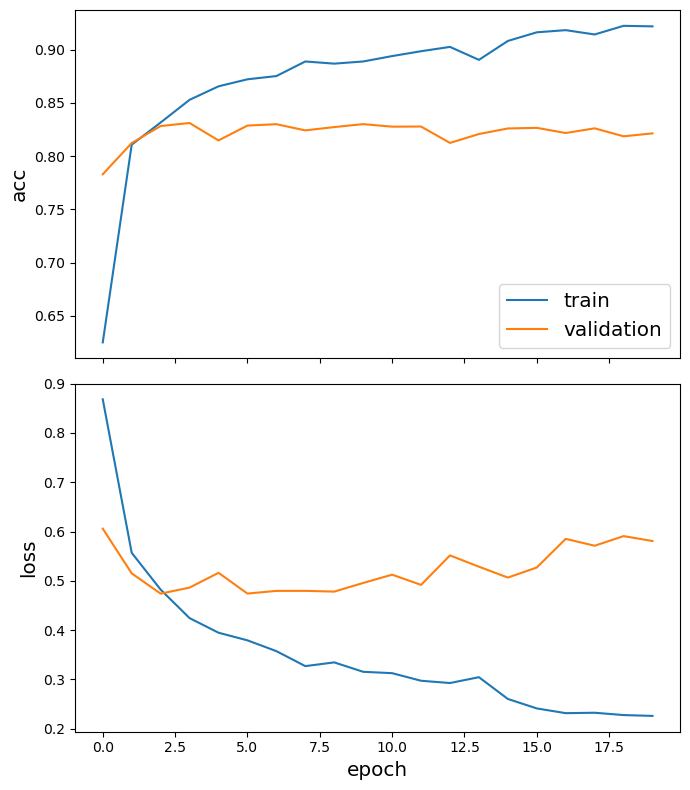

In [50]:
sg.utils.plot_history(history)

In [51]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

355/355 [==============================] - 156s 439ms/step - loss: 0.5788 - acc: 0.8219

Test Set Metrics:
	loss: 0.5788
	acc: 0.8219


### Benchmark model

In [ ]:
# print benchmarking results
targets = np.argmax( test_targets, axis=1 )
predictions = np.argmax( model.predict(test_gen), axis=1 )

In [ ]:
train_acc, precision, recall, f1 = benchmarking_result( targets, predictions )

print( "Accuracy: ", train_acc )
print( "Precision: ", precision )
print( "Recall: ", recall )
print( "F1: ", f1 )

# this result is wrong

In [ ]:
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

In [ ]:
node_predictions = le.inverse_transform(all_predictions)

In [ ]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(10)

In [ ]:
# calculate accuracy
df['Correct'] = df['Predicted'] == df['True']
df['Correct'].value_counts()

In [ ]:
accuracy = df['Correct'].value_counts()[True] / df['Correct'].value_counts().sum()
print( accuracy )

## GCN model

In [52]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.7, test_size=None, stratify=node_subjects
)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=0.5, test_size=None, stratify=test_subjects
)

In [53]:
train_subjects.value_counts().to_frame() # why is equal to demo?

,0
2,5512
3,5417
1,2872


In [54]:
# Convert to numeric labels
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
val_targets = le.transform(val_subjects)
test_targets = le.transform(test_subjects)

In [55]:
generator = FullBatchNodeGenerator(SG, method="gcn")

Using GCN (local pooling) filters...


In [56]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [57]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [58]:
x_inp, x_out = gcn.in_out_tensors()

In [59]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Train model

In [60]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam( learning_rate=0.005 ),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [61]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [62]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [63]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 2s - loss: 1.0992 - acc: 0.2533 - val_loss: 1.0944 - val_acc: 0.5139 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 1s - loss: 1.0943 - acc: 0.4829 - val_loss: 1.0890 - val_acc: 0.6278 - 677ms/epoch - 677ms/step
Epoch 3/200
1/1 - 0s - loss: 1.0890 - acc: 0.5610 - val_loss: 1.0827 - val_acc: 0.6278 - 439ms/epoch - 439ms/step
Epoch 4/200
1/1 - 0s - loss: 1.0830 - acc: 0.5793 - val_loss: 1.0752 - val_acc: 0.6325 - 419ms/epoch - 419ms/step
Epoch 5/200
1/1 - 0s - loss: 1.0754 - acc: 0.5994 - val_loss: 1.0665 - val_acc: 0.6471 - 448ms/epoch - 448ms/step
Epoch 6/200
1/1 - 0s - loss: 1.0676 - acc: 0.6129 - val_loss: 1.0576 - val_acc: 0.6636 - 410ms/epoch - 410ms/step
Epoch 7/200
1/1 - 0s - loss: 1.0592 - acc: 0.6245 - val_loss: 1.0488 - val_acc: 0.6768 - 368ms/epoch - 368ms/step
Epoch 8/200
1/1 - 1s - loss: 1.0510 - acc: 0.6374 - val_loss: 1.0398 - val_acc: 0.6805 - 516ms/epoch - 516ms/step
Epoch 9/200
1/1 - 0s - loss: 1.0430 - acc: 0.6448 - val_loss: 1.0302 - val_acc: 0.6832 - 404ms

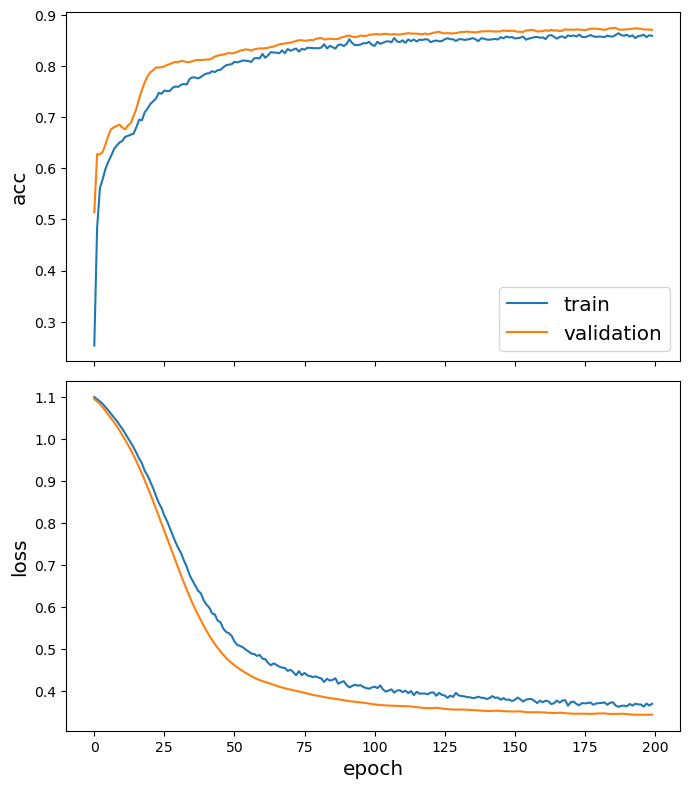

In [64]:
sg.utils.plot_history(history)

In [65]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [66]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 113ms/step - loss: 0.3500 - acc: 0.8692

Test Set Metrics:
	loss: 0.3500
	acc: 0.8692


## GAT model

In [67]:
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

In [69]:
# split data
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.7, test_size=None, stratify=node_subjects
)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=0.5, test_size=None, stratify=test_subjects
)

In [70]:
from collections import Counter

Counter(train_subjects)

Counter({3: 5417, 2: 5512, 1: 2872})

In [71]:
# Convert to numeric labels
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
val_targets = le.transform(val_subjects)
test_targets = le.transform(test_subjects)

In [72]:
# Create the GAT model
generator = FullBatchNodeGenerator(SG, method="gat")

In [73]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [74]:
gat = GAT(
    layer_sizes=[16, 16],
    activations=["elu", "elu"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

In [75]:
x_inp, x_out = gat.in_out_tensors()

In [76]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [77]:
model = Model(inputs=x_inp, outputs= predictions)
model.compile(
    optimizer=optimizers.Adam( learning_rate=0.005 ),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [78]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [79]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [80]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/200
1/1 - 6s - loss: 1.1144 - acc: 0.3261 - val_loss: 1.0480 - val_acc: 0.5909 - 6s/epoch - 6s/step
Epoch 2/200
1/1 - 1s - loss: 1.0588 - acc: 0.4733 - val_loss: 1.0022 - val_acc: 0.6251 - 959ms/epoch - 959ms/step
Epoch 3/200
1/1 - 1s - loss: 1.0205 - acc: 0.5122 - val_loss: 0.9621 - val_acc: 0.6410 - 1s/epoch - 1s/step
Epoch 4/200
1/1 - 1s - loss: 0.9826 - acc: 0.5383 - val_loss: 0.9251 - val_acc: 0.6528 - 922ms/epoch - 922ms/step
Epoch 5/200
1/1 - 1s - loss: 0.9525 - acc: 0.5522 - val_loss: 0.8881 - val_acc: 0.6589 - 1s/epoch - 1s/step
Epoch 6/200
1/1 - 1s - loss: 0.9236 - acc: 0.5674 - val_loss: 0.8488 - val_acc: 0.6640 - 924ms/epoch - 924ms/step
Epoch 7/200
1/1 - 1s - loss: 0.8928 - acc: 0.5887 - val_loss: 0.8063 - val_acc: 0.6748 - 954ms/epoch - 954ms/step
Epoch 8/200
1/1 - 1s - loss: 0.8568 - acc: 0.6127 - val_loss: 0.7612 - val_acc: 0.7032 - 1s/epoch - 1s/step
Epoch 9/200
1/1 - 1s - loss: 0.8212 - acc: 0.6409 - val_loss: 0.7155 - val_acc: 0.7471 - 1s/epoch - 1s/step
Epoc

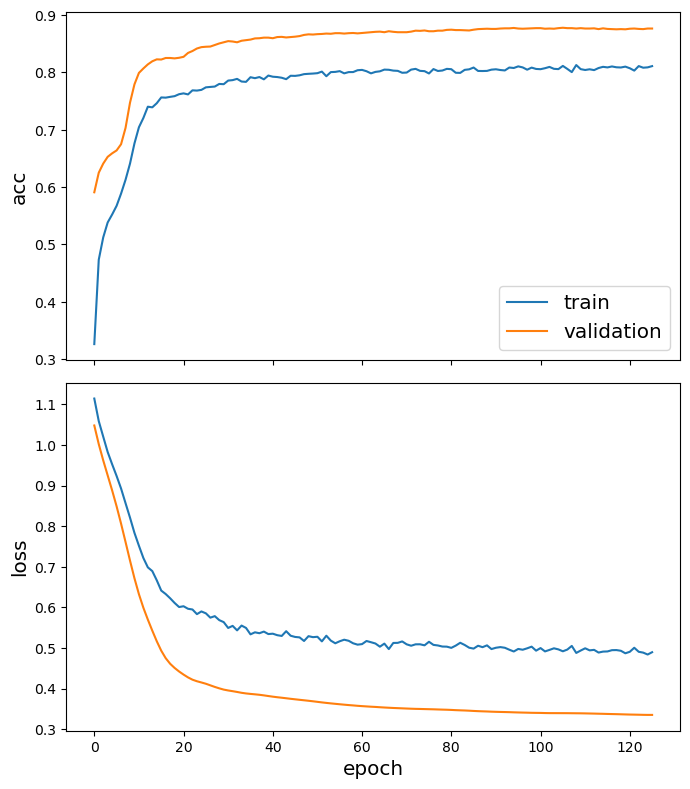

In [81]:
sg.utils.plot_history(history)

In [82]:
model.load_weights("logs/best_model.h5")

In [83]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [84]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 210ms/step - loss: 0.3481 - acc: 0.8668

Test Set Metrics:
	loss: 0.3481
	acc: 0.8668


In [ ]:
# shape of test_gen
print( test_gen.__len__() )

In [85]:
# Compute F1 score
from sklearn.metrics import f1_score

y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_targets, axis=1)

f1_score(y_true, y_pred, average="micro")

1/1 [==============================] - 1s 867ms/step


ValueError: Found input variables with inconsistent numbers of samples: [2958, 1]

In [ ]:
# print size of y_pred and y_true
print(y_pred.shape)